[Link to Page](https://tutorials.pytorch.kr/beginner/blitz/neural_networks_tutorial.html)

1. weight를 갖는 `신경망 정의`
2. `데이터셋 입력` 반복
3. 입력을 신경망에 `전파`(forward pass)
4. `손실(Loss)`을 계산
5. gradient를 `역으로 전파`(backward)
6. 신경망의 `weight를 갱신` $$weight = weight - lr * gradient$$

# 신경망 정의

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# torch.nn --> 미니배치만 지원하므로 4차원! 하나의 샘플만 있다면 unsqueeze(0)을 통해 차원 추가

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv layer
        self.conv1 = nn.Conv2d(1, 6, 3)  # 입력 채널 1, 출력 채널 6, 3x3 커널
        self.conv2 = nn.Conv2d(6, 16, 3)  # 입력 채널 6, 출력 채널 16, 3x3 커널

        # fc layer (Affine)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 : 이미지 차원 ( 32 x 32 input)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 maxpooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print(x.size())
        # flatten
        x = x.view(-1, self.num_flat_features(x))
        # fc layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] # 배치 차원 제외 모든 차원 ( batch, channel, h, w)
        num_features = 1
        for s in size:
            num_features *= s # channel * h * w
        return num_features
    
net = Net()
print(net)
    

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1의 weight

10
torch.Size([6, 1, 3, 3])


In [3]:
# input 32x32

input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out) # 10 output

tensor([[ 0.0922,  0.0256, -0.0434,  0.0590,  0.0176,  0.0706, -0.1600,  0.0888,
         -0.0288,  0.0272]], grad_fn=<AddmmBackward>)


In [4]:
# 무작위 값으로 역전파

net.zero_grad()
out.backward(torch.randn(1, 10))

# Loss Function

In [5]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1) # 출력과 같은 shape
criterian = nn.MSELoss() # MSE loss

loss = criterian(output, target) # pred, GT loss
print(loss)


tensor(1.2732, grad_fn=<MseLossBackward>)


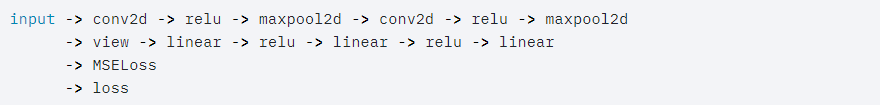

In [6]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

# Backprop

In [7]:
net.zero_grad() # 모든 매개변수의 gradient 0

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
print("===============================")
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0194,  0.0197,  0.0117, -0.0236, -0.0069,  0.0059])


# 가중치 갱신

In [8]:
learning_rate = 0.01
for f in net.parameters():
    # 모든 파라미터에 대해서 가중치 갱신
    f.data.sub_(f.grad.data * learning_rate) # inplace 연산 weight -= grad * lr

In [ ]:
import torch.optim as optim

# optimizer 생성
optimizer = optim.SGE(net.parameters(), lr = 0.01)

# training
optimizer.zero_grad()
output = net(input)
los